In [98]:
import pandas as pd
import numpy as np
import csv
from datetime import datetime, time
from django.utils import timezone
import pytz
from alive_progress import alive_bar

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set_theme()

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# no text wrapping
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 400)

In [2]:
df_spec = pd.read_pickle('.\\calculations\\df_spec.pickle')
df_arch = pd.read_pickle('.\\calculations\\df_arch.pickle')

In [101]:
problems = ['GD_2367', 'GD_2368', 'GD_3039', 'GD_3040', 'GD_3041', 'GD_3042']

the old version of the import:
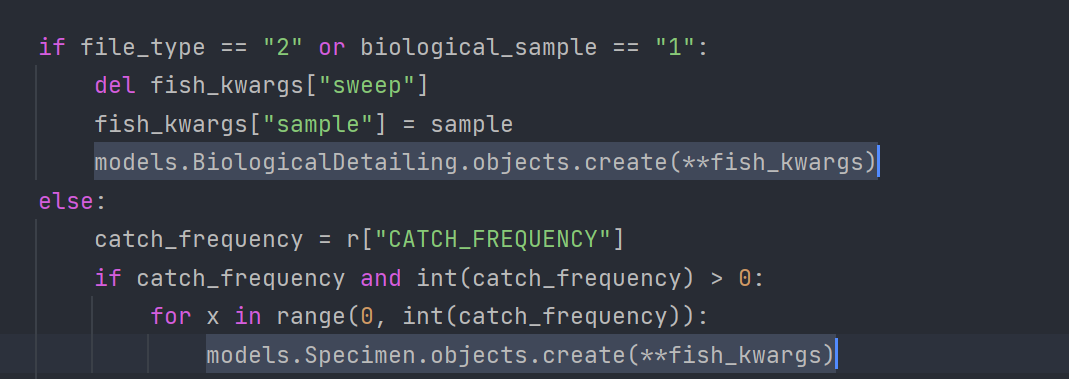

the newer version of the import (where the potential error ocurred):
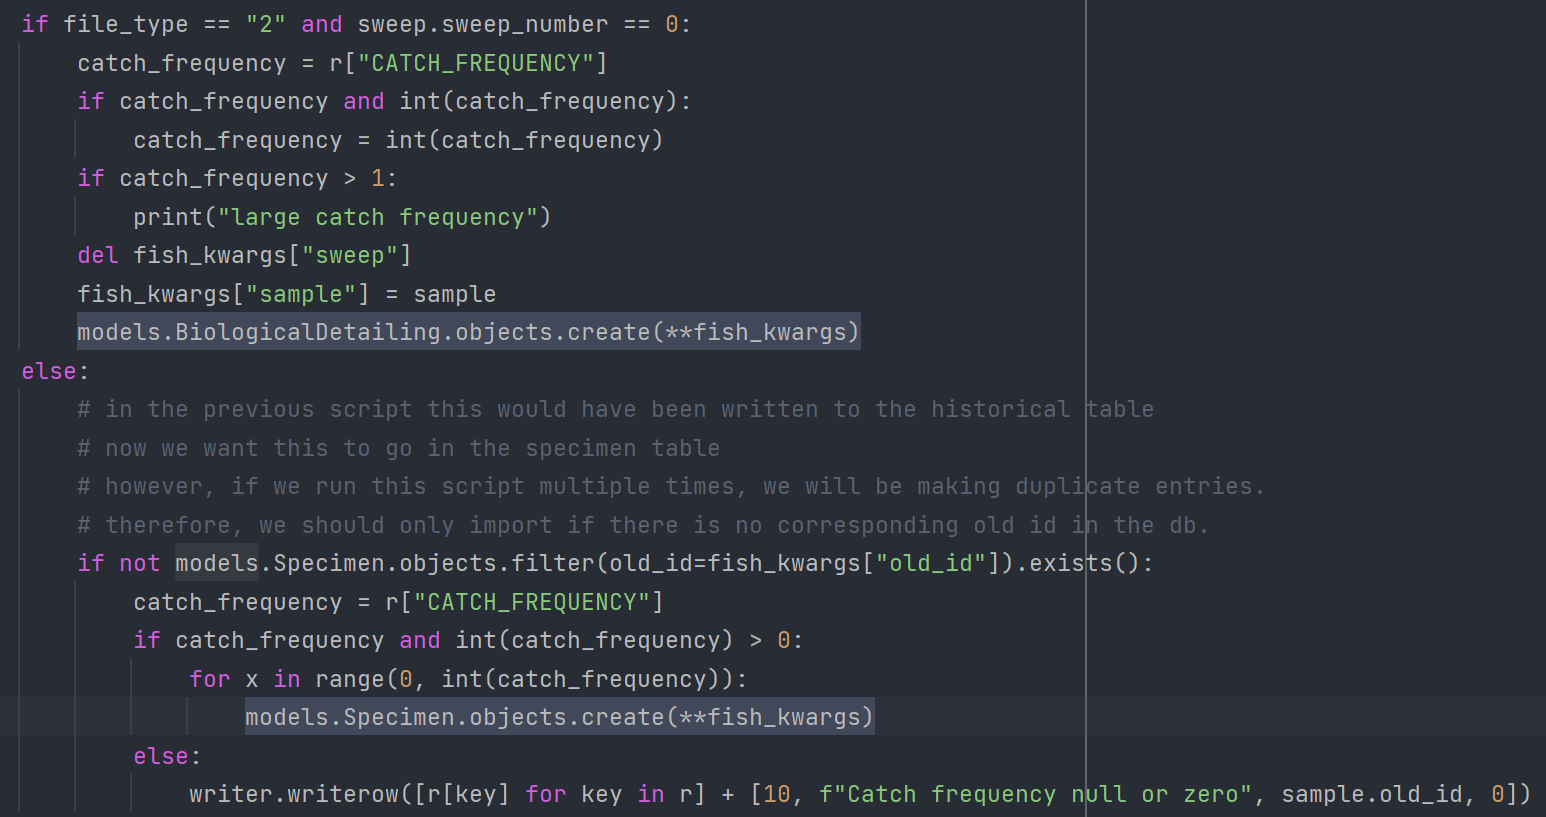

* this script only considers samples with 
        
        file_type == '2' and biological_sample == '1'
* the problem imports occured because file_type was Null (even though sweep.sweep_number == 0)
* should it have been this instead?

        file_type == '2' or biological_sample == '1'
        
* are there situations where null file_type and sweep_number==0 is NOT a biological specimen?

what is file_type==2?
    
    "FILE_TYPE: either 1 (regular sample) or 2 (biological sample)"

what is sweep_number==0?

    SWEEP_NUMBER: if successive removal, values from 1 to 6, if single/CPUE pass value = 0.5,
    if non-monitoring sampling sweep =0, notes that certain sites are ‘calibration sites’ i.e. a cpue pass is conducted followed by several successive removal passes

    SWEEP_number = 0 Sites; if there are no SWEEP0_TIME, in that site a subsample of the fish caught during the various sweep was measures to the closest mm and sometimes weighted and/or sacrificed for sexing. Unfortunately the sweep during which these fish were caught was not recorded. For these sites its important to not include sweep_number = 0 fish to the total number of fish caught during the various sweeps.









In [100]:
df_arch[df_arch.old_id.isin(problems)].BIOLOGICAL_SAMPLE.value_counts()

1.000    6
Name: BIOLOGICAL_SAMPLE, dtype: int64

In [91]:
df_arch[df_arch.old_id.isin(problems)].T.drop(['BIOLOGICAL_REMARKS', 'arch_matching_id'])
# FILE_TYPE = NaN seems to be the import issue

,2366,2367,3038,3039,3040,3041
old_id,GD_2367,GD_2368,GD_3039,GD_3040,GD_3041,GD_3042
DATETIME,1971-09-08 00:00:00,1971-09-08 00:00:00,1971-07-27 00:00:00,1971-07-27 00:00:00,1971-07-27 00:00:00,1971-07-27 00:00:00
SURVEY,1971,1971,1971,1971,1971,1971
SITE,13,13,58,58,58,58
CATCHMENT_NAME,MIRAMICHI,MIRAMICHI,MIRAMICHI,MIRAMICHI,MIRAMICHI,MIRAMICHI
CATCHMENT_INDEX,2,2,2,2,2,2
SURVEY_TYPE,1,1,1,1,1,1
SITE_EVENT_CODE,1,1,1,1,1,1
SWEEP_NUMBER,0.000,0.000,0.000,0.000,0.000,0.000
RECORD_IDENTIFIER,8628334,8628335,8626673,8626674,8626675,8626676


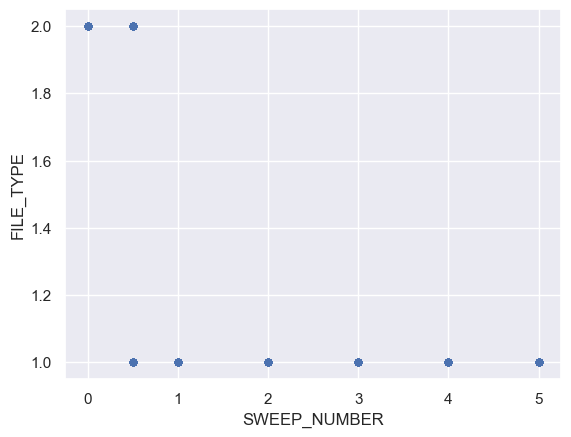

In [5]:
# how does sweep compare with file_type?
df_arch.plot(kind='scatter', y='FILE_TYPE', x='SWEEP_NUMBER');

In [6]:
# potential import problems
df_arch[
    (df_arch.SWEEP_NUMBER==0) 
    & (df_arch.FILE_TYPE.isnull()) 
    & (df_arch.BIOLOGICAL_SAMPLE==1) 
    & (df_arch.SEX.notnull())
].describe().T

,count,mean,std,min,25%,50%,75%,max
SURVEY,20.000,1970.300,0.470,1970.000,1970.000,1970.000,1971.000,1971.000
CATCHMENT_INDEX,20.000,2.000,0.000,2.000,2.000,2.000,2.000,2.000
SURVEY_TYPE,20.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
SITE_EVENT_CODE,20.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
SWEEP_NUMBER,20.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
SPECIES_LIFE_STAGE,20.000,1731.000,0.000,1731.000,1731.000,1731.000,1731.000,1731.000
FORK_LENGTH,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FORK_LENGTH_INTERVAL_WIDTH,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TOTAL_LENGTH,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WEIGHT,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# out of samples with bio data, only these 6 have been imported into spec which also include bio detailing
#  sweep==0 & file_type==NULL
df_spec[
    df_spec.old_id.isin(
       df_arch[
            (df_arch.SWEEP_NUMBER==0) 
            & (df_arch.FILE_TYPE.isnull()) 
        ].old_id.unique()
    )
]

,id,fork_length,weight,river_age,notes,sample_id,sex_id,status_id,age_type,sweep_id,life_stage_id,old_id,smart_river_age,smart_river_age_type,matching_id
2259,2230972,<NA>,NaN,0.000,None,4456,1,5.000,1.000,14123.000,11.000,GD_2367,0.000,1.000,445600_01
2260,2230973,<NA>,NaN,0.000,None,4456,1,5.000,1.000,14123.000,11.000,GD_2368,0.000,1.000,445600_01
2696,2233822,<NA>,NaN,1.000,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,4475,2,4.000,1.000,14139.000,1.000,GD_3039,1.000,1.000,447500_02
2697,2233823,<NA>,NaN,1.000,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,4475,2,4.000,1.000,14139.000,1.000,GD_3040,1.000,1.000,447500_02
2698,2233824,<NA>,NaN,1.000,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,4475,2,4.000,1.000,14139.000,1.000,GD_3041,1.000,1.000,447500_02
2699,2233825,<NA>,NaN,1.000,Field FISH _STATUS changed from R to MZ to reflect that that would be the only way to get sexing info GD - Nov 2022,4475,1,4.000,1.000,14139.000,1.000,GD_3042,1.000,1.000,447500_01


In [9]:
# however, we should check the full dataset to see if there are any other problem imports
df_all = pd.read_csv('.\\raw_data\\trapnet_specimen_202302231329.csv', low_memory=False)

df_checkthis = df_all[
    df_all.old_id.isin(
       df_arch[
            (df_arch.SWEEP_NUMBER==0) 
            & (df_arch.FILE_TYPE.isnull()) 
        ].old_id.unique()
    )
].copy()

# 53 have sex info, 38 have maturity, 58 have either/or
df_checkthis.describe().T

,count,mean,std,min,25%,50%,75%,max
id,8404.000,1895825.033,44778.771,1871112.000,1886580.750,1891688.500,1894183.250,2233825.000
fork_length,7647.000,67.702,23.725,21.000,50.000,64.000,84.000,180.000
total_length,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weight,6576.000,4.990,5.025,0.100,1.470,3.000,6.800,32.700
river_age,8303.000,0.617,0.714,0.000,0.000,0.000,1.000,3.000
created_by_id,8404.000,50.000,0.000,50.000,50.000,50.000,50.000,50.000
origin_id,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sample_id,8404.000,6162.269,245.824,4413.000,6147.000,6210.000,6242.000,8156.000
sex_id,53.000,1.132,0.342,1.000,1.000,1.000,1.000,2.000
species_id,8404.000,78.688,3.459,2.000,79.000,79.000,79.000,80.000


In [46]:
df_comparison = pd.concat([
    pd.DataFrame(df_checkthis.notnull().sum() / df_checkthis.shape[0], columns=['prop_filtered']),
    pd.DataFrame(df_all.notnull().sum() / df_all.shape[0], columns=['prop_all']),
    pd.DataFrame(df_checkthis.notnull().sum() / df_checkthis.shape[0], columns=['difference']) / \
    pd.DataFrame(df_all.notnull().sum() / df_all.shape[0], columns=['difference'])
], axis=1)

In [59]:
# top 10 differences between data to check and full dataset
df_comparison.sort_values('difference', ascending=False)  #.head(10)
# weight, age, length
# NOTE: there is actually less sex data in the problem data then the average for the dataset

,prop_filtered,prop_all,difference
maturity_id,0.005,0.000,92.895
weight,0.782,0.202,3.866
age_type,0.988,0.390,2.535
smart_river_age_type,0.988,0.392,2.517
river_age,0.988,0.401,2.466
smart_river_age,0.988,0.403,2.453
fork_length,0.910,0.482,1.888
life_stage_id,0.990,0.598,1.656
old_id,1.000,0.724,1.382
adipose_condition,1.000,0.725,1.380


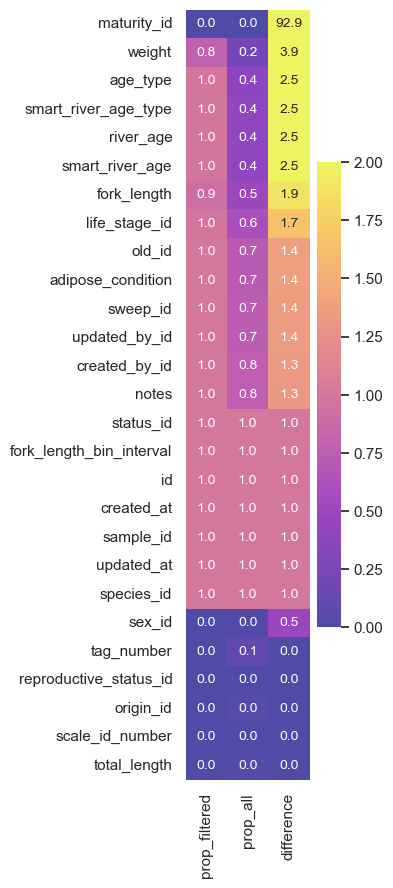

In [80]:
plt.figure(figsize=(2,10))
sns.heatmap(df_comparison.sort_values('difference', ascending=False).dropna(), vmin=0, vmax=2, cmap='plasma', alpha=0.7, annot=True, fmt='.1f', annot_kws={"fontsize":10})
plt.show()

In [81]:
# what about sweep 0.5, that is a lot

df_all[
    df_all.old_id.isin(
       df_arch[
            ((df_arch.SWEEP_NUMBER==0) | (df_arch.SWEEP_NUMBER==0.5))
            & (df_arch.FILE_TYPE.isnull()) 
        ].old_id.unique()
    )
].shape, df_checkthis.shape

((260021, 28), (8404, 28))

In [83]:
# status id == 5 is 'sampled'
df_checkthis[df_checkthis.status_id==5].describe()

,id,fork_length,total_length,weight,river_age,created_by_id,origin_id,sample_id,sex_id,species_id,status_id,updated_by_id,age_type,ocean_age,sweep_id,life_stage_id,reproductive_status_id,adipose_condition,fork_length_bin_interval,maturity_id,smart_river_age,smart_river_age_type
count,1004.000,301.000,0.000,301.000,1004.000,1004.000,0.000,1004.000,4.000,1004.000,1004.000,1004.000,1004.000,0.000,1004.000,1004.000,0.000,1004.000,1004.000,0.000,1004.000,1004.000
mean,1937031.325,61.738,NaN,2.677,0.216,50.000,NaN,5983.931,1.000,79.000,5.000,50.000,1.867,NaN,7402.325,9.685,NaN,1.000,1.000,NaN,0.216,1.867
std,112615.052,7.797,NaN,0.678,0.596,0.000,NaN,614.647,0.000,0.000,0.000,0.000,0.340,NaN,2629.412,3.381,NaN,0.000,0.000,NaN,0.596,0.340
min,1886052.000,37.000,NaN,0.600,0.000,50.000,NaN,4413.000,1.000,79.000,5.000,50.000,1.000,NaN,6291.000,1.000,NaN,1.000,1.000,NaN,0.000,1.000
25%,1891777.750,57.000,NaN,2.300,0.000,50.000,NaN,6147.000,1.000,79.000,5.000,50.000,2.000,NaN,6360.000,11.000,NaN,1.000,1.000,NaN,0.000,2.000
50%,1895171.500,66.000,NaN,3.000,0.000,50.000,NaN,6242.000,1.000,79.000,5.000,50.000,2.000,NaN,6399.000,11.000,NaN,1.000,1.000,NaN,0.000,2.000
75%,1895734.250,66.000,NaN,3.100,0.000,50.000,NaN,6254.000,1.000,79.000,5.000,50.000,2.000,NaN,6402.000,11.000,NaN,1.000,1.000,NaN,0.000,2.000
max,2230973.000,66.000,NaN,3.100,3.000,50.000,NaN,6258.000,1.000,79.000,5.000,50.000,2.000,NaN,14123.000,11.000,NaN,1.000,1.000,NaN,3.000,2.000


In [86]:
# 4 and 5 are from the problem imports, they equate to MZ and R ('mortality research removal (fish euthanasied)' and 'released unsampled')
# why do they have sex and age data if they are unsampled?
df_arch.FISH_STATUS.value_counts()

RS    287939
R      24929
MZ      6055
M       2539
RL        12
           1
Y          1
Name: FISH_STATUS, dtype: int64

In [99]:
df_checkthis[df_checkthis.maturity_id.notnull() | df_checkthis.sex_id.notnull()].drop(['created_at', 'updated_at', 'notes'], axis=1)

,id,fork_length,total_length,weight,river_age,scale_id_number,created_by_id,origin_id,sample_id,sex_id,species_id,status_id,updated_by_id,tag_number,age_type,ocean_age,sweep_id,life_stage_id,reproductive_status_id,adipose_condition,old_id,fork_length_bin_interval,maturity_id,smart_river_age,smart_river_age_type
467461,1892603,77.000,NaN,4.000,2.000,NaN,50.000,NaN,6224,NaN,79,4.000,50.000,NaN,1.000,NaN,6372.000,1.000,NaN,1.000,GD_91709,1.000,2.000,2.000,1.000
467467,1892609,90.000,NaN,8.700,2.000,NaN,50.000,NaN,6224,NaN,79,4.000,50.000,NaN,1.000,NaN,6372.000,1.000,NaN,1.000,GD_91715,1.000,1.000,2.000,1.000
467470,1892612,98.000,NaN,11.400,2.000,NaN,50.000,NaN,6224,NaN,79,4.000,50.000,NaN,1.000,NaN,6372.000,1.000,NaN,1.000,GD_91718,1.000,2.000,2.000,1.000
467505,1892647,72.000,NaN,4.600,1.000,NaN,50.000,NaN,6225,1.000,79,4.000,50.000,NaN,1.000,NaN,6373.000,1.000,NaN,1.000,GD_91753,1.000,4.000,1.000,1.000
467521,1892663,81.000,NaN,7.000,1.000,NaN,50.000,NaN,6225,NaN,79,4.000,50.000,NaN,1.000,NaN,6373.000,1.000,NaN,1.000,GD_91769,1.000,3.000,1.000,1.000
467522,1892664,82.000,NaN,5.600,1.000,NaN,50.000,NaN,6225,NaN,79,4.000,50.000,NaN,1.000,NaN,6373.000,1.000,NaN,1.000,GD_91770,1.000,3.000,1.000,1.000
467524,1892666,95.000,NaN,10.700,2.000,NaN,50.000,NaN,6225,1.000,79,4.000,50.000,NaN,1.000,NaN,6373.000,1.000,NaN,1.000,GD_91772,1.000,4.000,2.000,1.000
467526,1892668,104.000,NaN,14.600,2.000,NaN,50.000,NaN,6225,1.000,79,4.000,50.000,NaN,1.000,NaN,6373.000,1.000,NaN,1.000,GD_91774,1.000,4.000,2.000,1.000
467528,1892670,117.000,NaN,20.000,2.000,NaN,50.000,NaN,6225,1.000,79,4.000,50.000,NaN,1.000,NaN,6373.000,1.000,NaN,1.000,GD_91776,1.000,4.000,2.000,1.000
469267,1894409,113.000,NaN,15.660,2.000,NaN,50.000,NaN,6245,1.000,79,10.000,50.000,NaN,2.000,NaN,6393.000,1.000,NaN,1.000,GD_93424,1.000,4.000,2.000,2.000


In [108]:
# all of these potential issues are marked as bio sample or not at all...
df_arch[df_arch.old_id.isin(df_checkthis.old_id.unique())].BIOLOGICAL_SAMPLE.value_counts(dropna=False)

NaN      7373
1.000     150
Name: BIOLOGICAL_SAMPLE, dtype: int64

In [109]:
df_checkthis.sample_id.unique()

array([6012, 6013, 6015, 6016, 6030, 6031, 6033, 6037, 6038, 6040, 6041,
       6070, 6071, 6073, 6074, 6083, 6084, 6086, 6096, 6097, 6100, 6134,
       6135, 6136, 6137, 6138, 6139, 6140, 6141, 6143, 6144, 6145, 6146,
       6147, 6150, 6151, 6152, 6153, 6154, 6180, 6181, 6182, 6183, 6184,
       6187, 6188, 6189, 6190, 6192, 6193, 6194, 6195, 6196, 6198, 6199,
       6200, 6201, 6202, 6203, 6204, 6205, 6206, 6207, 6208, 6210, 6211,
       6212, 6213, 6214, 6215, 6216, 6217, 6218, 6222, 6223, 6224, 6225,
       6226, 6227, 6228, 6229, 6231, 6232, 6233, 6234, 6235, 6237, 6238,
       6239, 6240, 6241, 6242, 6243, 6244, 6245, 6246, 6247, 6248, 6249,
       6250, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6258, 8156, 4413,
       4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4423, 4424,
       4425, 4426, 4428, 4430, 4431, 4438, 4456, 4475], dtype=int64)